<a href="https://colab.research.google.com/github/rodriquiel/concrete_images_classifier/blob/main/modified_resnet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo ResNet50

El proyecto a continuacion se basa en la creacion de un clasificador de imagenes utilizando el modelo preentrenados ResNet50.

Las imagenes son de diferentes estructuras de hormigon, y lo que se busca predecir es si el mismo se encuentra agrietado o no.

### Importacion librerias y paquetes

In [1]:
!pip install keras
!pip install skillsnetwork
!pip install tensorflow

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
!pip install skillsnetwork

In [3]:
import numpy as np
import keras
import skillsnetwork
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt

## Descarga de datos

Se descargan los datos desde el almacenamiento de objetos de IBM utilizando el comando **skillsnetwork.prepare**, el cual permite descargar un archivo zip, descomprimirlo y almacenarlo en un directorio especifico

**Importante**: Si ejecuta el colab, podra ver la carpeta *concrete_data_week* en el panel izquierdo, la cual contiene dos carpetas: *train* y *valid*, las cuales contienen en su interior dos subcarpetas. *positive* y *negative*, cada una con imagenes correspondientes a su categoria. Para el caso de las negativas, se trata de imagenes de concreto sin grietas, mientras que las positivas son imagenes de concreto con grietas.
Cada carpeta contiene cientos de imagenes, por lo que se recomienda **no abrir las carpetas con los nombres positive y negative**, ya que lo mas probable es que al intentarlo, se consuma toda su memoria y finalice con un error 50.

In [4]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/concrete_data_week3.zip", overwrite=True)

  0%|          | 0/30036 [00:00<?, ?it/s]

Saved to '.'


## Definicion de constantes globales

Se definen algunas constantes que seran utilizadas a lo largo del desarrollo:

*   *num_clases*: representa el numero de clases, para este caso serán 2 (positivo o negativo).
*   *image_resize*: el modelo ResNet50 fue construido y entrenado utilizando imagenes de tamaño (224x224), por lo que se debe redimensionar las imagenes del conjunto de datos de (227x227) a (224x224).
*   *batch_size_training y batch_size_validation*: se entrenará y validará el modelo usando lotes de 100 imagenes.



In [5]:
num_classes = 2
image_resize = 224
batch_size_training = 100
batch_size_validation = 100

## Construccion de ImageDataGenerator

Keras ImageDataGenerator requiere que las imágenes se organicen en una determinada jerarquía de carpetas, donde el directorio principal contenga carpetas iguales a la cantidad de clases en su problema. En este caso, ya se cumple con la condicion por lo expresado en la seccion de *Descarga de Datos*}

Para crear una instancia de ImageDataGenerator, se establece el argumento **preprocessing_function** en *preprocess_input* importado desde **keras.applications.resnet50** para preprocesar las imágenes de la misma manera que se procesaron las imágenes usadas para entrenar el modelo ResNet50.

In [6]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

Luego se utiliza el metodo *flow_from_directory* para obtener las imagenes de entrenamiento y validacion

In [7]:
train_generator = data_generator.flow_from_directory(
    'concrete_data_week3/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 10001 images belonging to 2 classes.


In [8]:
validation_generator = data_generator.flow_from_directory(
    'concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 5001 images belonging to 2 classes.


## Construccion y entrenamiento del modelo

Se utiliza la Sequential model class de Keras

In [9]:
model = Sequential()

Despues, se añade el modelo pre-entrenado ResNet50 al modelo definido previamente. Se puede observar en el codigo que no se añade la capa superior del modelo pre-entrenado ya que lo que se busca es definir una capa de salida propia y entrenarla para que este optimizada con el conjunto de datos de imagenes descargado.

In [10]:
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Luego, se define la capa de salida como una capa **Densa**, que consta de dos nodos y se utiliza la función **Softmax** como función de activación.

In [11]:
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.layers

[<Functional name=resnet50, built=True>, <Dense name=dense, built=False>]

Se puede observar que el modelo está compuesto por dos conjuntos de capas. El primer conjunto son las capas que pertenecen a ResNet50 y el segundo conjunto es una sola capa, que es la capa densa que definida anteriormente.

Como el ResNet50 ya está entrenado, hay que comunicarle al modelo que no entrene la parte del modelo pre-entrenado, sino solo la parte de la capa densa

In [13]:
model.layers[0].trainable = False

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Y ahora, usando el atributo *summary* del modelo, puede verse cuántos parámetros deben optimizarse para entrenar la capa de salida.

In [15]:
#model.summary()

Antes de poder empezar con el entrenamiento con los ImageDataGenerator, se deben difinir cuantos steps componen una epoca.

In [16]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

A diferencia de un entrenamiento de deep learning convencional donde los datos no se transmiten desde un directorio, con un ImageDataGenerator donde los datos se encuentran en lotes, se usa el método **fit**.

In [17]:
fit_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 69s 508ms/step - accuracy: 0.9392 - loss: 0.1716 - val_accuracy: 0.9952 - val_loss: 0.0186


Con el modelo ya entrenado, se pueden clasificar imagenes de concreto para saber si contienen grietas o no. Ya que el modelo tarda un tiempo considerable en entrenarse, se guarda el modelo como un *.keras* para poder usarlo a futuro sin tener que repetir todo el proceso.

In [18]:
model.save('classifier_resnet_model.keras')

### Prueba del modelo con imagenes externas

In [19]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [20]:
ruta_imagen = '/content/imagen_prueba.jpg'

In [21]:
image = load_img(ruta_imagen, target_size=(image_resize, image_resize))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = preprocess_input(image_array)

In [22]:
imagen = Image.open(ruta_imagen)
imagen_redimensionada = imagen.resize((224, 224))
imagen_redimensionada.save('imagen_redimensionada.jpg')

In [23]:
image_array = img_to_array(imagen_redimensionada)
image_array = np.expand_dims(image_array, axis=0)
image_array = preprocess_input(image_array)


In [24]:
predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [25]:
predicted_class

array([1])

In [26]:
predicted_classes = np.argmax(predictions, axis=1)

In [28]:
if predicted_classes[0] == 1:
    print("La imagen contiene grietas.")
else:
    print("La imagen no contiene grietas.")

La imagen contiene grietas.


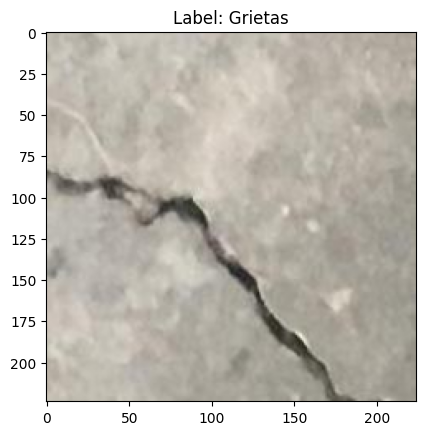

In [29]:
plt.imshow(imagen_redimensionada)
plt.title(f'Label: {"Grietas" if predicted_class[0] == 1 else "Sin grietas"}')
plt.show()
